In [1]:
#Pelayo Leguina - 2024

#Este script permite convertir un archivo ROOT con clases tipo TClonesArray a un DataFrame de pandas.

# Para correr este script es necesario tener instalado ROOT y pandas
# Para tener root instalado, hay que generar el env con conda. 
# Mira el archivo environment.yml para ver cómo hacerlo. Una vez tengas el env creado, activa el env y ejecuta este notebook. 
# Puedes seguir trabajando aqui o exportar el dataframe a un archivo csv para trabajar en otro lado.


import ROOT
import pandas as pd

# Definir la ruta del archivo ROOT y el nombre del árbol
ruta_archivo_root = 'DTDPGNtuple_12_4_2_Phase2Concentrator_Simulation_89.root'
nombre_arbol = 'dtNtupleProducer/DTTREE'

# Abrir el archivo ROOT
archivo = ROOT.TFile.Open(ruta_archivo_root)
if not archivo or archivo.IsZombie():
    raise FileNotFoundError(f"No se pudo abrir el archivo ROOT en {ruta_archivo_root}")

# Obtener el árbol
arbol = archivo.Get(nombre_arbol)
if not arbol:
    raise ValueError(f"No se encontró el árbol '{nombre_arbol}' en el archivo ROOT.")

# Listas de ramas
ramas_event = ['event_eventNumber']
ramas_digis_numericas = ["digi_nDigis", "digi_wheel", "digi_sector", "digi_station", 
    "digi_superLayer", "digi_layer", "digi_wire", "digi_time"]
ramas_seg_numericas = [
    "seg_nSegments", "seg_wheel", "seg_sector", "seg_station", "seg_hasPhi", 
    "seg_hasZed", "seg_posLoc_x", "seg_posLoc_y", "seg_posLoc_z", 
    "seg_dirLoc_x", "seg_dirLoc_y", "seg_dirLoc_z", "seg_posLoc_x_SL1", 
    "seg_posLoc_x_SL3", "seg_posLoc_x_midPlane", "seg_posGlb_phi", 
    "seg_posGlb_eta", "seg_dirGlb_phi", "seg_dirGlb_eta", "seg_phi_t0", 
    "seg_phi_vDrift", "seg_phi_normChi2", "seg_phi_nHits", 
    "seg_z_normChi2", "seg_z_nHits"
]
ramas_seg_arrays = [
    'seg_phiHits_pos', 'seg_phiHits_posCh', 'seg_phiHits_posErr', 
    'seg_phiHits_side', 'seg_phiHits_wire', 'seg_phiHits_wirePos', 
    'seg_phiHits_layer', 'seg_phiHits_superLayer', 'seg_phiHits_time', 
    'seg_phiHits_timeCali'
]

ramas_a_extraer = ramas_event + ramas_digis_numericas + ramas_seg_numericas + ramas_seg_arrays

# Inicializar diccionario para almacenar los datos
data = {rama: [] for rama in ramas_a_extraer}

# Iterar sobre las entradas del árbol
for evento in arbol:
    for rama in ramas_a_extraer:
        valor = getattr(evento, rama, None)
        
        if valor is None:
            data[rama].append(None)
            continue

        # Verificar si es un TClonesArray
        if hasattr(valor, 'GetEntriesFast'):
            valores = []
            for i in range(valor.GetEntriesFast()):
                elemento = valor.At(i)
                if hasattr(elemento, '__len__'):  # Si es vectorizable
                    valores.append([x for x in elemento])
                else:
                    valores.append(elemento)
            data[rama].append(valores)
        elif isinstance(valor, ROOT.TVectorF) or isinstance(valor, ROOT.TVectorD):
            # Manejar TVectorT como TVectorF (float) o TVectorD (double)
            data[rama].append([valor[i] for i in range(valor.GetNrows())])
        elif isinstance(valor, (int, float)):
            # Escalar simple
            data[rama].append(valor)
        else:
            try:
                # Intentar convertir a lista si es iterable
                data[rama].append(list(valor))
            except TypeError:
                data[rama].append(valor)

# Cerrar el archivo ROOT
archivo.Close()

# Verificar que todas las ramas tienen la misma longitud
longitudes = {rama: len(val) for rama, val in data.items()}
print("Longitud de cada rama:")
for rama, longitud in longitudes.items():
    print(f"{rama}: {longitud}")

# Convertir a DataFrame
try:
    df = pd.DataFrame(data)
except ValueError as e:
    print("Error al crear el DataFrame:", e)
    for rama, longitud in longitudes.items():
        print(f"{rama}: {longitud}")
    raise

# Mostrar una vista previa del DataFrame
print("\nVista previa del DataFrame:")
print(df.head())

# Contar los hits en las ramas tipo array
for rama in ramas_seg_arrays:
    if rama in df.columns:
        df[f'{rama}_count'] = df[rama].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Mostrar conteos
for rama in ramas_seg_arrays:
    if f'{rama}_count' in df.columns:
        print(f"\nNúmero de hits por evento en '{rama}':")
        print(df[f'{rama}_count'].head())

# Guardar el DataFrame en un archivo CSV
df.to_csv('data.csv', index=False)
print('Data saved in data.csv')

#Ahora ya puedes trabajar con el df para generar las entradas/verdades de tu modelo de ML
#Siempre asegurate de preprocesar el df, rellenar los NaNs, normalizar los datos, etc.

#Recuerda que deberíamos filtrar los digis pertenecientes a la SL2 (no trabajamos en esa dimension)
#Lo mismo para los segmentos que no tienen hits en phi (son segmentos de la SL2 y tambien tenemos que cargarnoslos)
# Suerte! :)

Longitud de cada rama:
event_eventNumber: 439
digi_nDigis: 439
digi_wheel: 439
digi_sector: 439
digi_station: 439
digi_superLayer: 439
digi_layer: 439
digi_wire: 439
digi_time: 439
seg_nSegments: 439
seg_wheel: 439
seg_sector: 439
seg_station: 439
seg_hasPhi: 439
seg_hasZed: 439
seg_posLoc_x: 439
seg_posLoc_y: 439
seg_posLoc_z: 439
seg_dirLoc_x: 439
seg_dirLoc_y: 439
seg_dirLoc_z: 439
seg_posLoc_x_SL1: 439
seg_posLoc_x_SL3: 439
seg_posLoc_x_midPlane: 439
seg_posGlb_phi: 439
seg_posGlb_eta: 439
seg_dirGlb_phi: 439
seg_dirGlb_eta: 439
seg_phi_t0: 439
seg_phi_vDrift: 439
seg_phi_normChi2: 439
seg_phi_nHits: 439
seg_z_normChi2: 439
seg_z_nHits: 439
seg_phiHits_pos: 439
seg_phiHits_posCh: 439
seg_phiHits_posErr: 439
seg_phiHits_side: 439
seg_phiHits_wire: 439
seg_phiHits_wirePos: 439
seg_phiHits_layer: 439
seg_phiHits_superLayer: 439
seg_phiHits_time: 439
seg_phiHits_timeCali: 439

Vista previa del DataFrame:
   event_eventNumber  digi_nDigis  \
0              52244          120   
1       

In [2]:
from newGeo.dtGeometry import *
from itertools import chain
import logging

geometry_xml_path = "newGeo/DTGeometry.xml"


# Parse DT Geometry XML
print("\nParsing DT Geometry XML...")
df_geometry = parse_dtgeometry_xml(geometry_xml_path)

def create_wire_position_mapping(df_geometry):
    mapping = {}
    for idx, row in df_geometry.iterrows():
        chamber_rawId = row['Chamber_rawId']
        superLayerNumber = row['SuperLayerNumber']
        layerNumber = row['LayerNumber']
        channels_total = row['Channels_total']
        wireFirst = row['WirePositions_FirstWire']
        wireLast = row['WirePositions_LastWire']
        # Create Wire object to get positions
        wire_obj = Wire(wireFirst, wireLast, channels_total, row['Layer_Local_z'])
        # Map wire numbers to positions
        for wire_idx, x_pos in enumerate(wire_obj.positions):
            wire_number = wire_idx + 1  # Assuming wire numbers start from 1
            key = (chamber_rawId, superLayerNumber, layerNumber, wire_number)
            mapping[key] = x_pos
    return mapping


def explode_dataframe(df, list_columns):
    """Explota columnas con listas en filas separadas."""
    # Repetir índices según la longitud de las listas
    lengths = df[list_columns[0]].apply(len)
    idx = df.index.repeat(lengths)

    # Explotar las columnas de listas
    exploded_data = {col: list(chain.from_iterable(df[col])) for col in list_columns}

    # Agregar las columnas que no son listas
    exploded_df = pd.DataFrame(exploded_data, index=idx)
    non_list_columns = df.columns.difference(list_columns)
    for col in non_list_columns:
        exploded_df[col] = df[col].repeat(lengths)

    return exploded_df.reset_index(drop=True)

def add_chamber_rawId_to_digis(df):
    """Agrega la columna chamber_rawId basada en wheel, station y sector."""
    chamber_rawIds = []
    for idx, row in df.iterrows():
        try:
            rawId = get_rawId(row['digi_wheel'], row['digi_station'], row['digi_sector'])
        except ValueError as e:
            logging.error(f"Error al calcular rawId en el índice {idx}: {e}")
            rawId = None
        chamber_rawIds.append(rawId)
    df['digi_chamber_rawId'] = chamber_rawIds
    return df

def map_digi_wires_to_positions(df, wire_position_mapping):
    """Mapea los wires a sus posiciones en x usando wire_position_mapping."""
    x_positions = []
    for idx, row in df.iterrows():
        key = (row['digi_chamber_rawId'], row['digi_superLayer'], row['digi_layer'], row['digi_wire'])
        x_pos = wire_position_mapping.get(key, None)  # Por defecto, None si no se encuentra la clave
        x_positions.append(x_pos)
    df['digi_x_pos'] = x_positions
    return df

def reconstruct_dataframe(df_original, df_flattened, list_columns, extra_columns):
    """
    Reconstruye el DataFrame original, agrupando las columnas calculadas en listas.

    Args:
    - df_original: DataFrame original con listas.
    - df_flattened: DataFrame aplanado después de las explosiones y cálculos.
    - list_columns: Columnas que originalmente estaban en formato de lista.
    - extra_columns: Nuevas columnas a agregar al DataFrame.

    Returns:
    - DataFrame reconstruido con las columnas adicionales.
    """
    # Crear índice auxiliar para asociar filas a las originales
    df_flattened["original_index"] = df_original.index.repeat(
        df_original[list_columns[0]].apply(len)
    )

    # Agrupar filas aplanadas según el índice original
    grouped = df_flattened.groupby("original_index")

    # Agregar de vuelta las columnas originales y las nuevas
    for col in list_columns + extra_columns:
        df_original[col] = grouped[col].apply(list).reindex(df_original.index).tolist()

    return df_original



wire_position_mapping = create_wire_position_mapping(df_geometry)

# Columnas con valores en listas
list_columns = ['digi_wheel', 'digi_sector', 'digi_station', 'digi_superLayer', 'digi_layer', 'digi_wire']

# Explotar el DataFrame para trabajar con cada digi individualmente
df_flattened = explode_dataframe(df, list_columns)

# Agregar la columna chamber_rawId
df_flattened = add_chamber_rawId_to_digis(df_flattened)

# Calcular las posiciones de los wires
df_flattened = map_digi_wires_to_positions(df_flattened, wire_position_mapping)

# Reconstruir el DataFrame original con la nueva columna
df = reconstruct_dataframe(df, df_flattened, list_columns, ['digi_x_pos'])

# Reordenar columnas para que digi_x_pos aparezca después de digi_wire
columns = df.columns.tolist()
digi_wire_index = columns.index('digi_wire')
columns.insert(digi_wire_index + 1, columns.pop(columns.index('digi_x_pos')))
df = df[columns]

# Mostrar el DataFrame final 
print(df.head())



Parsing DT Geometry XML...
   event_eventNumber  digi_nDigis  \
0              52244          120   
1              52251           92   
2              52242          123   
3              52254          117   
4              52248           43   

                                          digi_wheel  \
0  [-1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [2, 2, 2, 2, 2, 2, 2, -2, -2, -2, -2, -2, -2, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -2, -2...   
3  [-1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
4  [2, 2, 2, 2, -1, -1, -1, -1, -1, -1, -1, -1, -...   

                                         digi_sector  \
0  [1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
1  [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, ...   
2  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [3, 5, 7, 7, 12, 12, 12, 12, 12, 12, 4, 4, 4, ...   

                                        digi_station  \
0  [1, 1, 1, 1, 1, 

In [3]:
# Ramas relacionadas con 'digis'
ramas_digis = [
    "event_eventNumber",
    "digi_nDigis", "digi_wheel", "digi_sector", "digi_station", 
    "digi_superLayer", "digi_layer", "digi_wire", "digi_time"
]

# Ramas relacionadas con 'segments' (seg)
ramas_segments = [
    "event_eventNumber",
    "seg_nSegments",
    "seg_wheel",
    "seg_sector",
    "seg_station",
    "seg_hasPhi",
    "seg_hasZed",
    "seg_posLoc_x",
    "seg_posLoc_y",
    "seg_posLoc_z",
    "seg_dirLoc_x",
    "seg_dirLoc_y",
    "seg_dirLoc_z",
    "seg_posLoc_x_SL1",
    "seg_posLoc_x_SL3",
    "seg_posLoc_x_midPlane",
    "seg_posGlb_phi",
    "seg_posGlb_eta",
    "seg_dirGlb_phi",
    "seg_dirGlb_eta",
    "seg_phi_t0",
    "seg_phi_vDrift",
    "seg_phi_normChi2",
    "seg_phi_nHits",
    "seg_z_normChi2",
    "seg_z_nHits",
    "seg_phiHits_wire",
    "seg_phiHits_layer",
    "seg_phiHits_superLayer"
]

# Combinar todas las ramas a extraer
ramas_a_extraer = ramas_digis + ramas_segments


In [4]:
# Extraer las ramas relacionadas con 'digis' en un DataFrame de pandas
df_digis = df[ramas_digis]

# Extraer las ramas relacionadas con 'segments' en otro DataFrame de pandas
df_segments = df[ramas_segments]

In [5]:
# Función para convertir Awkward Arrays a listas de Python
def convertir_a_lista(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return list(x)
    return [x]  # En caso de que sea un valor escalar, lo convertimos en lista

# Aplicar la conversión a todas las columnas de 'digis' que son listas ( excepto 'event_eventNumber' )  

for col in ramas_digis:
        df_digis[col] = df_digis[col].apply(convertir_a_lista)

# Aplicar la conversión a todas las columnas de 'segments'
for col in ramas_segments:
    df_segments[col] = df_segments[col].apply(convertir_a_lista)

/tmp/ipykernel_7936/1917164315.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_digis[col] = df_digis[col].apply(convertir_a_lista)
/tmp/ipykernel_7936/1917164315.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segments[col] = df_segments[col].apply(convertir_a_lista)


### Primero manupulo los digis

In [6]:
# Definir las columnas relacionadas con 'digis' que serán aplanadas
columns_to_explode_digis = ['digi_superLayer', 'digi_layer', 'digi_wire', 'digi_time', 'digi_wheel', 'digi_sector', 'digi_station']

# Función para verificar si todas las listas tienen la misma longitud en una fila
def verificar_longitudes(row, cols):
    lengths = [len(row[col]) for col in cols]
    return len(set(lengths)) == 1  # True si todas las longitudes son iguales

# Aplicar la función a cada fila
df_digis['same_length'] = df_digis.apply(lambda row: verificar_longitudes(row, columns_to_explode_digis), axis=1)

# Verificar cuántas filas cumplen la condición
print("Número de filas con listas de la misma longitud en 'digis':")
print(df_digis['same_length'].value_counts())

# Filtrar solo las filas que cumplen la condición
df_digis = df_digis[df_digis['same_length']]

# Eliminar la columna auxiliar
df_digis = df_digis.drop(columns=['same_length'])


Número de filas con listas de la misma longitud en 'digis':
same_length
True    439
Name: count, dtype: int64


/tmp/ipykernel_7936/3591958675.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_digis['same_length'] = df_digis.apply(lambda row: verificar_longitudes(row, columns_to_explode_digis), axis=1)


In [7]:
# ahora vamos a aplanar las columnas de 'digis' que contienen listas
columns_to_explode_digis = [
    'digi_superLayer', 'digi_layer', 'digi_wire', 
    'digi_time', 'digi_wheel', 'digi_sector', 'digi_station'
]


df_digis_exploded = df_digis.explode(columns_to_explode_digis)

# Renombrar las columnas a nombres más cortos
df_digis_exploded = df_digis_exploded.rename(columns={
    "event_eventNumber": "eventNumber",
    "digi_superLayer": "superLayer",
    "digi_layer": "layer",
    "digi_wire": "wire",
    "digi_time": "time",
    "digi_wheel": "wheel",
    "digi_sector": "sector",
    "digi_station": "station"
})

# Convertir 'event_eventNumber' a entero, ya que antes era una lista
df_digis_exploded['eventNumber'] = df_digis_exploded['eventNumber'].apply(lambda x: x if isinstance(x, (int, str)) else x[0])

# Eliminar la columna 'digi_nDigis' ya que no es necesaria, puesto que cuenta el numero de digis en cada evento, no de cada estación
df_digis_exploded = df_digis_exploded.drop(columns=['digi_nDigis'])
# ELiminamos los digis de la superLayer 2, ya que no son necesarios y pueden influir en los resultados
df_digis_exploded = df_digis_exploded[df_digis_exploded['superLayer'] != 2]
#print("Preview of 'df_digis_exploded':")
#display(df_digis_exploded.head())

In [8]:
# Ahora vamos a agrupar los digis por evento y estación
df_digis_grouped = df_digis_exploded.groupby(
    ['eventNumber', 'wheel', 'sector', 'station']
).agg({
    'superLayer': list,
    'layer': list,
    'wire': list,
    'time': list
}).reset_index()

df_digis_grouped['n_digis'] = df_digis_grouped['wire'].apply(len)

# Mostrar una vista previa después de aplanar
print("Vista previa del DataFrame de 'digis' después de aplanar:")
display(df_digis_grouped.head())
df_digis_grouped.head()
tamaño_bytes = df_digis_grouped.memory_usage(deep=True).sum()
print(f"Tamaño del DataFrame en bytes: {tamaño_bytes}")

Vista previa del DataFrame de 'digis' después de aplanar:


,eventNumber,wheel,sector,station,superLayer,layer,wire,time,n_digis
0,52242,-2,4,1,"[1, 1, 1, 1]","[1, 2, 3, 4]","[39, 39, 38, 39]","[783.59375, 535.9375, 857.03125, 646.09375]",4
1,52242,-1,12,2,"[1, 1, 1, 1, 3, 3, 3, 3]","[1, 2, 3, 4, 1, 2, 3, 4]","[8, 9, 8, 9, 9, 10, 9, 10]","[593.75, 667.96875, 603.125, 660.15625, 641.40...",8
2,52242,1,2,1,"[1, 1, 1, 1, 3, 3, 3, 3]","[1, 2, 3, 4, 1, 2, 3, 4]","[16, 17, 17, 17, 20, 20, 20, 20]","[828.125, 553.90625, 662.5, 770.3125, 853.9062...",8
3,52242,1,2,2,"[1, 1, 1, 1, 3, 3, 3, 3]","[1, 2, 3, 4, 1, 2, 3, 4]","[16, 17, 16, 17, 16, 17, 16, 17]","[535.9375, 757.8125, 632.03125, 660.15625, 632...",8
4,52242,1,5,1,"[1, 1]","[1, 2]","[41, 42]","[596.09375, 667.1875]",2


Tamaño del DataFrame en bytes: 3583612


### Para hacer los grafos

In [9]:
# Eliminar las columnas 'time' no nos hacen falta para los nodos
df_digis_exploded_graph = df_digis_exploded.drop(columns=['time'])

#agrupar digis para hacer los grafos
df_digis_nodos = df_digis_exploded_graph.groupby(
    ['eventNumber', 'wheel', 'sector', 'station','superLayer']
).agg({
    'wire': list,
    'layer': list
}).reset_index()


#ESTO DE A CONTINUACION NO SE SI ES NECESARIO
# Si la lista de wire tiene menos de 4 elementos quitamos esa fila pues es ruido
# Filtrar las filas donde la longitud de la lista en 'wire' sea menor que 4
#df_digis_nodos = df_digis_nodos[df_digis_nodos['wire'].apply(len) >= 4]
#df_digis_nodos.head()

In [10]:
import itertools
import pandas as pd

# Función para construir nodos y aristas
def construir_aristas_con_nodos(row):
    wires = row['wire']  # Convertir a lista
    layers = row['layer']  # Convertir a lista

    nodos = [(wires[i], layers[i]) for i in range(len(wires))]  # Crear nodos como (wire, layer)
    aristas = []

    # Generar todas las combinaciones de nodos
    for i, j in itertools.combinations(range(len(nodos)), 2):
        wire_i, layer_i = nodos[i]
        wire_j, layer_j = nodos[j]

        # Verificar condiciones
        if abs(layer_i - layer_j) == 1 and abs(wire_i - wire_j) <= 1:
            aristas.append((nodos[i], nodos[j]))

    return nodos, aristas

# Aplicar al dataframe
df_digis_nodos['nodos'], df_digis_nodos['aristas'] = zip(*df_digis_nodos.apply(construir_aristas_con_nodos, axis=1))

# Visualizar un ejemplo
print(df_digis_nodos[['eventNumber', 'nodos', 'aristas']].head())

   eventNumber                                 nodos  \
0        52242  [(39, 1), (39, 2), (38, 3), (39, 4)]   
1        52242      [(8, 1), (9, 2), (8, 3), (9, 4)]   
2        52242    [(9, 1), (10, 2), (9, 3), (10, 4)]   
3        52242  [(16, 1), (17, 2), (17, 3), (17, 4)]   
4        52242  [(20, 1), (20, 2), (20, 3), (20, 4)]   

                                             aristas  
0  [((39, 1), (39, 2)), ((39, 2), (38, 3)), ((38,...  
1  [((8, 1), (9, 2)), ((9, 2), (8, 3)), ((8, 3), ...  
2  [((9, 1), (10, 2)), ((10, 2), (9, 3)), ((9, 3)...  
3  [((16, 1), (17, 2)), ((17, 2), (17, 3)), ((17,...  
4  [((20, 1), (20, 2)), ((20, 2), (20, 3)), ((20,...  


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Función para graficar el grafo de una fila
def graficar_grafo(eventNumber, aristas):
    # Crear el grafo
    G = nx.Graph()
    G.add_edges_from(aristas)

    # Dibujar el grafo
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G)  # Layout para una disposición atractiva
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=10)
    plt.title(f'Grafo para EventNumber: {eventNumber}')
    plt.show()

# Seleccionar ejemplos para graficar (primeras 3 filas)
for _, row in df_digis_nodos.head(2).iterrows():
    graficar_grafo(row['eventNumber'], row['aristas'])


In [12]:
#ahora hacemos lo mismo pero con torch
import torch
from torch_geometric.data import Data

# Función para construir el grafo
def construir_grafo_pyg(row):
    wires = row['wire']  
    layers = row['layer']  

    # Crear nodos como pares (wire, layer)
    nodos = [(wires[i], layers[i]) for i in range(len(wires))]

    # Crear mapa de nodos a índices
    nodo_indices = {nodo: idx for idx, nodo in enumerate(nodos)}

    # Generar aristas
    edge_index = []
    for i, j in itertools.combinations(range(len(nodos)), 2):
        wire_i, layer_i = nodos[i]
        wire_j, layer_j = nodos[j]

        if abs(layer_i - layer_j) == 1 and abs(wire_i - wire_j) <= 1:
            edge_index.append((nodo_indices[nodos[i]], nodo_indices[nodos[j]]))

    # Convertir a tensores de PyTorch
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor([[wire, layer] for wire, layer in nodos], dtype=torch.float)

    return Data(x=x, edge_index=edge_index)

# Ejemplo con la primera fila del dataframe
ejemplo_grafo = construir_grafo_pyg(df_digis_nodos.iloc[0])

print(ejemplo_grafo)

# Imprimir aristas en forma de pares de nodos
edge_index = ejemplo_grafo.edge_index
aristas = edge_index.t().tolist()  # Convertir a lista de pares
print("Aristas:", aristas)


Data(x=[4, 2], edge_index=[2, 3])
Aristas: [[0, 1], [1, 2], [2, 3]]


In [13]:
# Construir todos los grafos
grafos = [construir_grafo_pyg(row) for _, row in df_digis_nodos.iterrows()]

#crear el dataset
from torch_geometric.data import Dataset

class MiDataset(Dataset):
    def __init__(self, data_list):
        super().__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

dataset = MiDataset(grafos)


Data(x=[4, 2], edge_index=[2, 3])
Number of nodes: 4
Number of edges: 3
Average node degree: 0.75
Has isolated nodes: False
Has self-loops: False
Is undirected: False


/home/blanca_belmonte/miniconda3/envs/jupyter_ml_env/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


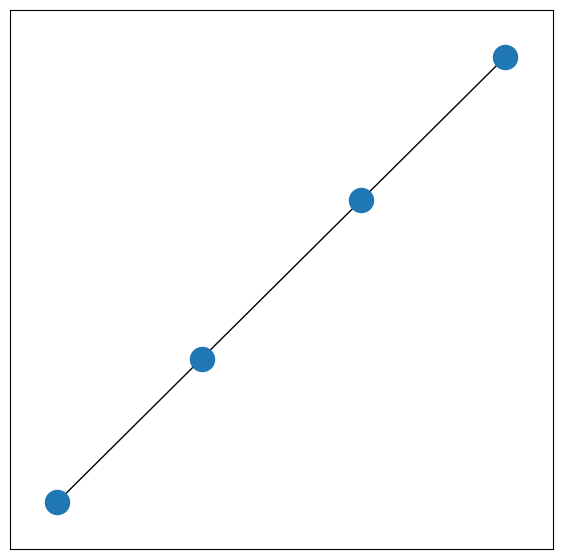

In [14]:
data = dataset[0]
print(data)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

from torch_geometric.utils import to_networkx

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()
    
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

### Ahora manipulo los segments

In [15]:
# Se construyen ahora la verdades con la parte de segments
# En concreto nos interesan las columnas seg_phiHits_wire y seg_phiHits_superlayer
# Creamos los grafos de la misma manera, primero aplanamos los datos

# Eliminar columnas de segmentos con las que no vamos a trabajar (todas menos 'event_eventNumber', 'seg_wheel', 'seg_sector', 'seg_station')
#Esto es porque de momento queremos solo predecir si hay o no segmentos en una estación, no cuantos ni su posición.

columnas_a_eliminar = [col for col in df_segments.columns if col not in ['event_eventNumber', 'seg_wheel', 'seg_sector', 'seg_station',"seg_phiHits_wire","seg_phiHits_layer","seg_phiHits_superLayer"]]

df_segments_filtered = df_segments.drop(columns=columnas_a_eliminar)

# Nos aseguramos de que 'event_eventNumber' sea un escalar, ya que antes convertimos todas las columnas a listas
df_segments_filtered['event_eventNumber'] = df_segments['event_eventNumber'].str[0]

# ahora vamos a aplanar las columnas de 'digis' que contienen listas
columns_to_explode_segments = [
    "seg_phiHits_superLayer", "seg_phiHits_layer", "seg_phiHits_wire", 
    'seg_wheel', 'seg_sector', 'seg_station'
]


df_segments_exploded = df_segments_filtered.explode(columns_to_explode_segments)

# Renombrar las columnas a nombres más cortos
df_segments_exploded = df_segments_exploded.rename(columns={
    "event_eventNumber": "eventNumber",
    "seg_phiHits_superLayer": "superLayer",
    "seg_phiHits_layer": "layer",
    "seg_phiHits_wire": "wire",
    'seg_wheel': "wheel",
    'seg_sector': "sector",
    'seg_station': "station"
})

# Nos aseguramos de que 'event_eventNumber' sea un escalar, ya que antes convertimos todas las columnas a listas
df_segments_exploded['event_eventNumber'] = df_segments['event_eventNumber'].str[0]

df_segments_exploded.head()

,eventNumber,wheel,sector,station,wire,layer,superLayer,event_eventNumber
0,52244,-1,1,1,[],[],[],52244
0,52244,0,5,1,"[33.0, 34.0, 33.0, 34.0, 34.0, 34.0, 34.0]","[1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 4.0]","[1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0]",52244
0,52244,0,5,1,"[33.0, 35.0, 37.0, 38.0]","[1.0, 4.0, 1.0, 3.0]","[1.0, 1.0, 3.0, 3.0]",52244
0,52244,0,5,1,"[33.0, 34.0, 34.0, 35.0]","[1.0, 1.0, 3.0, 4.0]","[1.0, 3.0, 3.0, 3.0]",52244
0,52244,0,5,1,"[34.0, 35.0, 34.0, 37.0]","[1.0, 2.0, 3.0, 1.0]","[1.0, 1.0, 1.0, 3.0]",52244


In [16]:
# hay que eliminar las filas que tienen listas vacias en wire, layer y superlayer puesto que estas pertenecen a la superlayer 2
# Identificar y eliminar filas donde col2 (u otra columna) tiene listas vacías
columnas_a_revisar = ["wire", 'layer', 'superLayer']  # Lista de columnas que queremos revisar
df_segments_exploded_limpio = df_segments_exploded[~df_segments_exploded[columnas_a_revisar].applymap(lambda x: isinstance(x, list) and len(x) == 0).any(axis=1)]
 
#convertimos a enteros
# Función para convertir los números de una lista a enteros
def convertir_a_enteros(lista):
    return [int(x) if isinstance(x, (float, int)) else x for x in lista]

# Aplicar la conversión solo a las columnas que contienen listas
df_segments_exploded_limpio["wire"] = df_segments_exploded_limpio["wire"].apply(convertir_a_enteros)
df_segments_exploded_limpio['layer'] = df_segments_exploded_limpio['layer'].apply(convertir_a_enteros)
df_segments_exploded_limpio['superLayer'] = df_segments_exploded_limpio['superLayer'].apply(convertir_a_enteros)


#volvemos a explotar
df_segments_exploded_2 = df_segments_exploded_limpio.explode(columnas_a_revisar)

# Ahora vamos a agrupar los digis por evento y estación
df_segments_nodos = df_segments_exploded_2.groupby(
    ['eventNumber', 'wheel', 'sector', 'station', 'superLayer']
).agg({
    'layer': list,
    'wire': list,
}).reset_index()

df_segments_nodos.head()

/tmp/ipykernel_7936/864493362.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_segments_exploded_limpio = df_segments_exploded[~df_segments_exploded[columnas_a_revisar].applymap(lambda x: isinstance(x, list) and len(x) == 0).any(axis=1)]


/tmp/ipykernel_7936/864493362.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segments_exploded_limpio["wire"] = df_segments_exploded_limpio["wire"].apply(convertir_a_enteros)
/tmp/ipykernel_7936/864493362.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segments_exploded_limpio['layer'] = df_segments_exploded_limpio['layer'].apply(convertir_a_enteros)
/tmp/ipykernel_7936/864493362.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

,eventNumber,wheel,sector,station,superLayer,layer,wire
0,52242,-2,4,1,1,"[1, 2, 3, 4]","[39, 39, 38, 39]"
1,52242,-1,12,2,1,"[1, 2, 3, 4]","[8, 9, 8, 9]"
2,52242,-1,12,2,3,"[1, 2, 3, 4]","[9, 10, 9, 10]"
3,52242,1,2,1,1,"[1, 2, 3, 4]","[16, 17, 17, 17]"
4,52242,1,2,1,3,"[1, 2, 3, 4]","[20, 20, 20, 20]"


In [17]:
#Construir los grafos
#con las definiciones de antes
# Aplicar al dataframe
df_segments_nodos['nodos'], df_segments_nodos['aristas'] = zip(*df_segments_nodos.apply(construir_aristas_con_nodos, axis=1))

# Visualizar un ejemplo
print(df_segments_nodos[['eventNumber', 'nodos', 'aristas']].head())

# Seleccionar ejemplos para graficar (primeras 3 filas)
#for _, row in df_segments_nodos.head(2).iterrows():
#    graficar_grafo(row['eventNumber'], row['aristas'])

   eventNumber                                 nodos  \
0        52242  [(39, 1), (39, 2), (38, 3), (39, 4)]   
1        52242      [(8, 1), (9, 2), (8, 3), (9, 4)]   
2        52242    [(9, 1), (10, 2), (9, 3), (10, 4)]   
3        52242  [(16, 1), (17, 2), (17, 3), (17, 4)]   
4        52242  [(20, 1), (20, 2), (20, 3), (20, 4)]   

                                             aristas  
0  [((39, 1), (39, 2)), ((39, 2), (38, 3)), ((38,...  
1  [((8, 1), (9, 2)), ((9, 2), (8, 3)), ((8, 3), ...  
2  [((9, 1), (10, 2)), ((10, 2), (9, 3)), ((9, 3)...  
3  [((16, 1), (17, 2)), ((17, 2), (17, 3)), ((17,...  
4  [((20, 1), (20, 2)), ((20, 2), (20, 3)), ((20,...  


In [18]:
#Con torch
# Ejemplo con la primera fila del dataframe
ejemplo_grafo = construir_grafo_pyg(df_segments_nodos.iloc[0])

print(ejemplo_grafo)

# Imprimir aristas en forma de pares de nodos
edge_index = ejemplo_grafo.edge_index
aristas = edge_index.t().tolist()  # Convertir a lista de pares
print("Aristas:", aristas)


Data(x=[4, 2], edge_index=[2, 3])
Aristas: [[0, 1], [1, 2], [2, 3]]


### Creo nuevos grafos a los que le incluyo la verdad ESTO DE MOMENTO NADA NO HACER CASO

In [19]:
#comparamos los dataframes para obtener la verdad

import ast

# Si la lista de wire tiene menos de 4 elementos quitamos esa fila pues es ruido
# Filtrar las filas donde la longitud de la lista en 'wire' sea menor que 4
#df_digis_nodos = df_digis_nodos[df_digis_nodos['wire'].apply(len) >= 4]
#df_digis_nodos.head()


df1 = df_digis_nodos
df2 = df_segments_nodos


# Columnas a usar para la comparación de correspondencia (excluyendo 'wire' y 'layer')
comparison_columns = ["eventNumber", "wheel", "sector", "station", "superLayer"]

# Crear una lista para almacenar los resultados
comparison_results = []

# Iterar sobre las filas de df1
for index1, row1 in df1.iterrows():
    # Buscar una fila correspondiente en df2
    match = df2[df2[comparison_columns].eq(row1[comparison_columns].values).all(axis=1)]
    if not match.empty:
        # Si se encuentra una fila correspondiente, comparar las listas
        index2 = match.index[0]  # Tomamos el primer match
        wire_comparison = []
        layer_comparison = []

        # Determinar la longitud máxima entre las listas
        max_len_wire = max(len(row1['wire']), len(df2.at[index2, 'wire']))
        max_len_layer = max(len(row1['layer']), len(df2.at[index2, 'layer']))

        # Comparar elementos de 'wire'
        for j in range(max_len_wire):
            wire_comparison.append(
                (row1['wire'][j] == df2.at[index2, 'wire'][j]) if j < len(row1['wire']) and j < len(df2.at[index2, 'wire']) else False
            )

        # Comparar elementos de 'layer'
        for j in range(max_len_layer):
            layer_comparison.append(
                (row1['layer'][j] == df2.at[index2, 'layer'][j]) if j < len(row1['layer']) and j < len(df2.at[index2, 'layer']) else False
            )

        comparison_results.append({
            'index_df1': index1,
            'index_df2': index2,
            'wire_comparison': wire_comparison,
            'layer_comparison': layer_comparison
        })

# Convertir los resultados a un DataFrame
df_comparison = pd.DataFrame(comparison_results)

# Mostrar el DataFrame de comparación
print(df_comparison)


KeyboardInterrupt: 

In [24]:
from itertools import zip_longest
#Lo mismo pero optimizado
df1 = df_digis_nodos
df2 = df_segments_nodos

# Columnas a usar para la comparación de correspondencia (excluyendo 'wire' y 'layer')
comparison_columns = ["eventNumber", "wheel", "sector", "station", "superLayer"]

# Unir los DataFrames usando las columnas relevantes
merged_df = pd.merge(df1, df2, on=comparison_columns, suffixes=('_df1', '_df2'))

# Función para comparar listas con manejo de longitudes distintas
def compare_lists(list1, list2):
    return [x == y if x is not None and y is not None else False for x, y in zip_longest(list1, list2)]

# Aplicar la comparación de listas a las columnas 'wire' y 'layer'
merged_df['wire_comparison'] = merged_df.apply(lambda row: compare_lists(row['wire_df1'], row['wire_df2']), axis=1)
merged_df['layer_comparison'] = merged_df.apply(lambda row: compare_lists(row['layer_df1'], row['layer_df2']), axis=1)

# Seleccionar solo las columnas de interés
df_verdad = merged_df[['wire_comparison', 'layer_comparison']]

# Mostrar el resultado
print(df_verdad)



                       wire_comparison                   layer_comparison
0             [True, True, True, True]           [True, True, True, True]
1             [True, True, True, True]           [True, True, True, True]
2             [True, True, True, True]           [True, True, True, True]
3             [True, True, True, True]           [True, True, True, True]
4             [True, True, True, True]           [True, True, True, True]
...                                ...                                ...
6766                [True, True, True]                 [True, True, True]
6767          [True, True, True, True]           [True, True, True, True]
6768  [True, True, True, False, False]  [True, True, False, False, False]
6769                            [True]                             [True]
6770         [True, True, True, False]          [True, True, True, False]

[6771 rows x 2 columns]


In [25]:
import torch
import itertools
from torch_geometric.data import Data

# Función para construir el grafo y agregar las etiquetas de la verdad
def construir_grafo_pyg_con_etiquetas(row, df_verdad):
    wires = row['wire']  
    layers = row['layer']  

    # Crear nodos como pares (wire, layer)
    nodos = [(wires[i], layers[i]) for i in range(len(wires))]

    # Crear mapa de nodos a índices
    nodo_indices = {nodo: idx for idx, nodo in enumerate(nodos)}

    # Generar aristas
    edge_index = []
    for i, j in itertools.combinations(range(len(nodos)), 2):
        wire_i, layer_i = nodos[i]
        wire_j, layer_j = nodos[j]

        # Conectar nodos solo si están en capas consecutivas y son cercanos en los wires
        if abs(layer_i - layer_j) == 1 and abs(wire_i - wire_j) <= 1:
            edge_index.append((nodo_indices[nodos[i]], nodo_indices[nodos[j]]))

    # Convertir a tensores de PyTorch
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor([[wire, layer] for wire, layer in nodos], dtype=torch.float)

    # Ahora asignamos las etiquetas de verdad según df_verdad
    # Asegurémonos de que df_verdad tiene el mismo número de nodos que el grafo
    verdad_etiquetas = []
    for i in range(len(nodos)):
        # Asignamos la etiqueta de la verdad a cada nodo basado en df_verdad
        # Usamos el índice 'i' para acceder a las columnas de 'wire' y 'layer' del df_verdad
        # Aquí asumo que las columnas 'wire' y 'layer' en df_verdad están relacionadas con los nodos
        etiqueta = 1 if df_verdad['wire_comparison'][i] and df_verdad['layer_comparison'][i] else 0
        verdad_etiquetas.append(etiqueta)

    # Convertir las etiquetas de verdad a un tensor de PyTorch
    y = torch.tensor(verdad_etiquetas, dtype=torch.long)

    # Retornar el objeto Data con las características de los nodos (x), las conexiones (edge_index), y las etiquetas de verdad (y)
    return Data(x=x, edge_index=edge_index, y=y)


# Construir el grafo con las etiquetas de la verdad
grafo_verdad = construir_grafo_pyg_con_etiquetas(df_digis_nodos.iloc[0], df_verdad.iloc[0])

# Imprimir el grafo resultante
print(grafo_verdad)

# Imprimir las aristas del grafo
edge_index = grafo_verdad.edge_index
aristas = edge_index.t().tolist()  # Convertir a lista de pares
print("Aristas:", aristas)

# Imprimir las etiquetas de la verdad
print("Verdad etiquetas:", grafo_verdad.y)


Data(x=[4, 2], edge_index=[2, 3], y=[4])
Aristas: [[0, 1], [1, 2], [2, 3]]
Verdad etiquetas: tensor([1, 1, 1, 1])


In [26]:
#CREAR DATASET

from torch_geometric.data import Data, Dataset, DataLoader

# Ahora, crearemos un dataset con múltiples grafos.
class MuonTrajectoryDataset(Dataset):
    def __init__(self, df_digis_nodos, df_verdad, transform=None):
        self.df_digis_nodos = df_digis_nodos
        self.df_verdad = df_verdad
        self.transform = transform  # Atributo transform, por si se desea aplicar alguna transformación

    def len(self):
        # Aquí devolvemos el tamaño del dataset, que es el número de filas en df_digis_nodos
        return len(self.df_digis_nodos)

    def get(self, idx):
        # Obtener la fila correspondiente al índice
        row = self.df_digis_nodos.iloc[idx]
        # Construir el grafo con la fila actual y las etiquetas de la verdad
        data = construir_grafo_pyg_con_etiquetas(row, self.df_verdad)

        # Si se define una transformación, aplicarla a los datos
        if self.transform:
            data = self.transform(data)

        return data
    
    def indices(self):
        # Implementar indices() para devolver el rango de índices
        return range(len(self.df_digis_nodos))



# Crear el dataset
dataset = MuonTrajectoryDataset(df_digis_nodos, df_verdad)

# Verificar el tamaño del dataset
print(f"Tamaño del dataset: {len(dataset)}")

# Crear un DataLoader para manejar los lotes
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Ejemplo de cómo acceder a los datos
for data in data_loader:
    print(data)


Tamaño del dataset: 10060
DataBatch(x=[5, 2], edge_index=[2, 3], y=[5], batch=[5], ptr=[3])
DataBatch(x=[6, 2], edge_index=[2, 4], y=[6], batch=[6], ptr=[3])
DataBatch(x=[8, 2], edge_index=[2, 6], y=[8], batch=[8], ptr=[3])
DataBatch(x=[7, 2], edge_index=[2, 4], y=[7], batch=[7], ptr=[3])
DataBatch(x=[9, 2], edge_index=[2, 3], y=[9], batch=[9], ptr=[3])
DataBatch(x=[11, 2], edge_index=[2, 10], y=[11], batch=[11], ptr=[3])
DataBatch(x=[6, 2], edge_index=[2, 3], y=[6], batch=[6], ptr=[3])
DataBatch(x=[22, 2], edge_index=[2, 26], y=[22], batch=[22], ptr=[3])
DataBatch(x=[8, 2], edge_index=[2, 6], y=[8], batch=[8], ptr=[3])
DataBatch(x=[3, 2], edge_index=[0], y=[3], batch=[3], ptr=[3])
DataBatch(x=[30, 2], edge_index=[2, 80], y=[30], batch=[30], ptr=[3])
DataBatch(x=[4, 2], edge_index=[2, 2], y=[4], batch=[4], ptr=[3])
DataBatch(x=[95, 2], edge_index=[2, 431], y=[95], batch=[95], ptr=[3])
DataBatch(x=[8, 2], edge_index=[2, 6], y=[8], batch=[8], ptr=[3])
DataBatch(x=[7, 2], edge_index=[2, 5

/home/blanca_belmonte/miniconda3/envs/jupyter_ml_env/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


DataBatch(x=[9, 2], edge_index=[2, 6], y=[9], batch=[9], ptr=[3])
DataBatch(x=[5, 2], edge_index=[2, 3], y=[5], batch=[5], ptr=[3])
DataBatch(x=[8, 2], edge_index=[2, 6], y=[8], batch=[8], ptr=[3])
DataBatch(x=[5, 2], edge_index=[2, 3], y=[5], batch=[5], ptr=[3])
DataBatch(x=[6, 2], edge_index=[2, 4], y=[6], batch=[6], ptr=[3])
DataBatch(x=[7, 2], edge_index=[2, 5], y=[7], batch=[7], ptr=[3])
DataBatch(x=[12, 2], edge_index=[2, 13], y=[12], batch=[12], ptr=[3])
DataBatch(x=[10, 2], edge_index=[2, 8], y=[10], batch=[10], ptr=[3])
DataBatch(x=[5, 2], edge_index=[2, 3], y=[5], batch=[5], ptr=[3])
DataBatch(x=[5, 2], edge_index=[2, 3], y=[5], batch=[5], ptr=[3])
DataBatch(x=[8, 2], edge_index=[2, 6], y=[8], batch=[8], ptr=[3])
DataBatch(x=[7, 2], edge_index=[2, 5], y=[7], batch=[7], ptr=[3])
DataBatch(x=[7, 2], edge_index=[2, 5], y=[7], batch=[7], ptr=[3])
DataBatch(x=[2, 2], edge_index=[0], y=[2], batch=[2], ptr=[3])
DataBatch(x=[8, 2], edge_index=[2, 6], y=[8], batch=[8], ptr=[3])
DataBa